### Импорт зависимостей

In [347]:
import os
import random
import shutil
from pathlib import Path

import kagglehub
from kagglehub import KaggleDatasetAdapter

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50V2

import matplotlib.pyplot as plt

### Загрузка датасета

In [272]:
dataset_path = kagglehub.dataset_download('harishekar/chess-board-state-detection-dataset')
dataset_path

'C:\\Users\\rayshite\\.cache\\kagglehub\\datasets\\harishekar\\chess-board-state-detection-dataset\\versions\\1'

### Разделение данных на обучающюю, валидационную и тестовую выборки

In [276]:
SRC_DIR = Path(dataset_path) / "final_original_dataset"
DEST_DIR = Path("data")

# доли выборок
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

random.seed(42)

for class_dir in SRC_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    class_name = class_dir.name 
    images = [p for p in class_dir.iterdir() if p.is_file()]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val  # остаток уходит в test

    splits = {
        "train": images[:n_train],
        "val":   images[n_train:n_train + n_val],
        "test":  images[n_train + n_val:],
    }

    for split_name, split_files in splits.items():
        target_dir = DEST_DIR / split_name / class_name
        target_dir.mkdir(parents=True, exist_ok=True)

        for src_path in split_files:
            dst_path = target_dir / src_path.name
            shutil.copy2(src_path, dst_path)

    print(f"{class_name}: total={n_total}, train={n_train}, val={n_val}, test={n_test}")

bB: total=100, train=70, val=15, test=15
bK: total=100, train=70, val=15, test=15
bN: total=100, train=70, val=15, test=15
bP: total=100, train=70, val=15, test=15
bQ: total=100, train=70, val=15, test=15
bR: total=100, train=70, val=15, test=15
empty: total=100, train=70, val=15, test=15
wB: total=100, train=70, val=15, test=15
wK: total=100, train=70, val=15, test=15
wN: total=100, train=70, val=15, test=15
wP: total=100, train=70, val=15, test=15
wQ: total=100, train=70, val=15, test=15
wR: total=100, train=70, val=15, test=15


In [278]:
train_dataset = image_dataset_from_directory(
    DEST_DIR / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    DEST_DIR / "val",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    DEST_DIR / "test",
    image_size=(180, 180),
    batch_size=32)

Found 910 files belonging to 13 classes.
Found 195 files belonging to 13 classes.
Found 195 files belonging to 13 classes.


### Вспомогательные методы

In [353]:
def visualize(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    acc = history_dict["accuracy"]
    val_acc  = history_dict["val_accuracy"]
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12, 5))           

    plt.subplot(1, 2, 1)                 
    plt.plot(epochs, loss_values, "b", label="Потери на этапе обучения")
    plt.plot(epochs, val_loss_values, "c", label="Потери на этапе проверки")
    plt.title("Потери на этапах обучения и проверки")
    plt.xlabel("Эпохи")
    plt.ylabel("Потери")
    plt.legend()

    plt.subplot(1, 2, 2)                  
    plt.plot(epochs, acc, "b", label="Точность на этапе обучения")
    plt.plot(epochs, val_acc, "c", label="Точность на этапе проверки")
    plt.title("Точность на этапах обучения и проверки")
    plt.xlabel("Эпохи")
    plt.ylabel("Точность")
    plt.legend()

    plt.tight_layout()                    
    plt.show()

In [355]:
def fit_model(model, checkpoint_path):
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"]
    )

    callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path,
          save_best_only=True,
          monitor="val_loss"
      ),
      keras.callbacks.EarlyStopping(
          monitor="val_loss",
          patience=10,
          restore_best_weights=True
      ),
      keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss",
          factor=0.5,
          patience=5,
          min_lr=1e-7
      )
    ]

    history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=validation_dataset,
      callbacks=callbacks
    )

    visualize(history)

In [334]:
def evaluate_model(checkpoint_path):
    model = keras.models.load_model(checkpoint_path)
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Точность на тестовых данных: {test_acc:.3f}")

### Создание базовой модели

In [306]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(13, activation="softmax")(x)
model_1 = keras.Model(inputs=inputs, outputs=outputs)

In [308]:
model_1.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_16 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 13)             │       163,085 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,581 (4.35 MB)

 Trainable params: 1,141,581 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

### Обучение базовой модели

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.1231 - loss: 2.4177 - val_accuracy: 0.2308 - val_loss: 1.9303 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.2538 - loss: 1.8467 - val_accuracy: 0.2769 - val_loss: 1.8658 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.3549 - loss: 1.6145 - val_accuracy: 0.3795 - val_loss: 1.6680 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.4582 - loss: 1.4570 - val_accuracy: 0.4103 - val_loss: 1.5990 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.4758 - loss: 1.4469 - val_accuracy: 0.4462 - val_loss: 1.5366 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.5110 - loss: 1.2468 - val_accuracy: 0.4615 - val_loss: 1.4481 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.6286 - loss: 1.

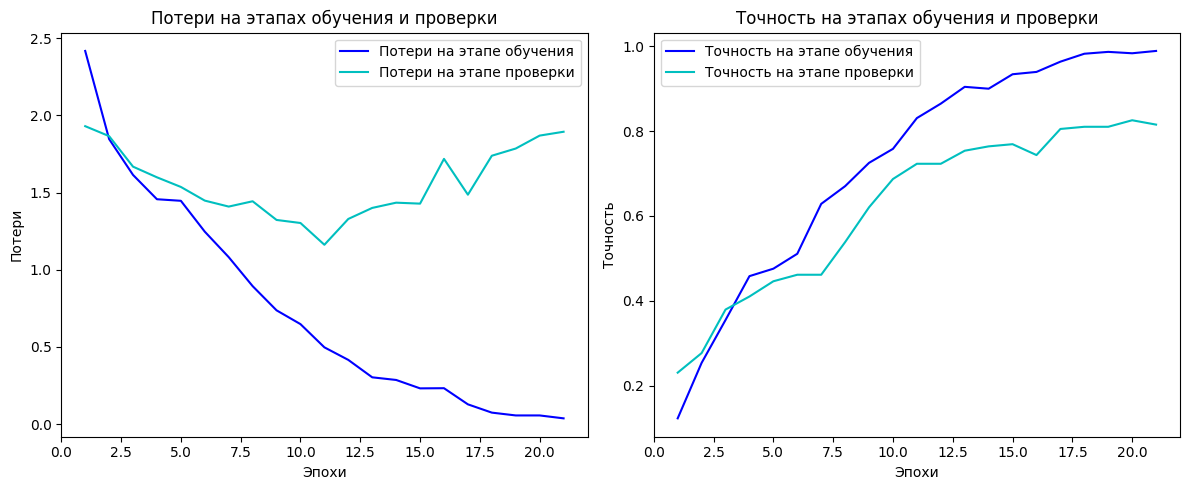

In [310]:
fit_model(model_1, "model_1.keras")

In [336]:
evaluate_model("model_1.keras")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7179 - loss: 1.0949
Точность на тестовых данных: 0.718


### Создание модели с обогащением с прореживанием


In [314]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(0.1, 0.1), 
        layers.RandomBrightness(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(13, activation="softmax")(x)
model_2 = keras.Model(inputs=inputs, outputs=outputs)

### Обучение улучшенной модели

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step - accuracy: 0.1110 - loss: 2.4536 - val_accuracy: 0.1897 - val_loss: 1.9896 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.2143 - loss: 2.1553 - val_accuracy: 0.2872 - val_loss: 2.0272 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.3000 - loss: 1.8573 - val_accuracy: 0.2872 - val_loss: 1.7385 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.3429 - loss: 1.7038 - val_accuracy: 0.3795 - val_loss: 1.5709 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.3429 - loss: 1.6410 - val_accuracy: 0.3795 - val_loss: 1.5802 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.4022 - loss: 1.5292 - val_accuracy: 0.4205 - val_loss: 1.4459 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.3593 - loss: 1.

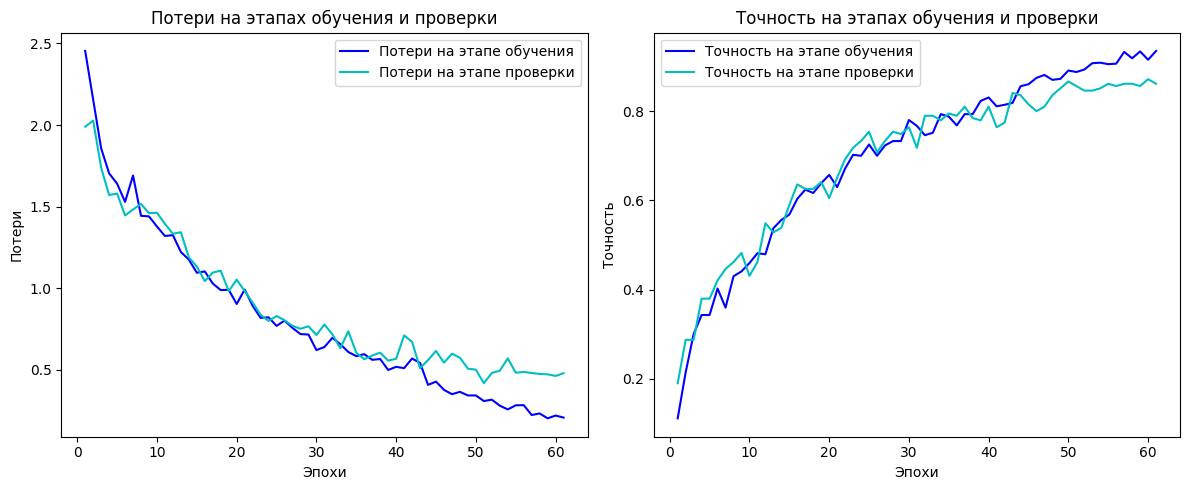

In [316]:
fit_model(model_2, "model_2.keras")

In [338]:
evaluate_model("model_2.keras")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8308 - loss: 0.5489
Точность на тестовых данных: 0.831


### Использование предобученной модели

In [341]:
base_model = ResNet50V2(
  input_shape=(180, 180, 3),
  include_top=False,           
  weights='imagenet'            
)

In [343]:
base_model.trainable = False

print(f"Базовая модель имеет {len(base_model.layers)} слоев")

Базовая модель имеет 190 слоев


In [359]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)  
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(13, activation="softmax")(x)
model_3 = keras.Model(inputs=inputs, outputs=outputs)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 640ms/step - accuracy: 0.3187 - loss: 2.0845 - val_accuracy: 0.7026 - val_loss: 1.0120 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 593ms/step - accuracy: 0.6725 - loss: 0.9268 - val_accuracy: 0.8154 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 588ms/step - accuracy: 0.7835 - loss: 0.6278 - val_accuracy: 0.8462 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 608ms/step - accuracy: 0.8319 - loss: 0.5106 - val_accuracy: 0.8974 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 609ms/step - accuracy: 0.8549 - loss: 0.4406 - val_accuracy: 0.9026 - val_loss: 0.3325 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 598ms/step - accuracy: 0.8802 - loss: 0.3626 - val_accuracy: 0.9333 - val_loss: 0.2534 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 601ms/step - accuracy: 0.9022 - l

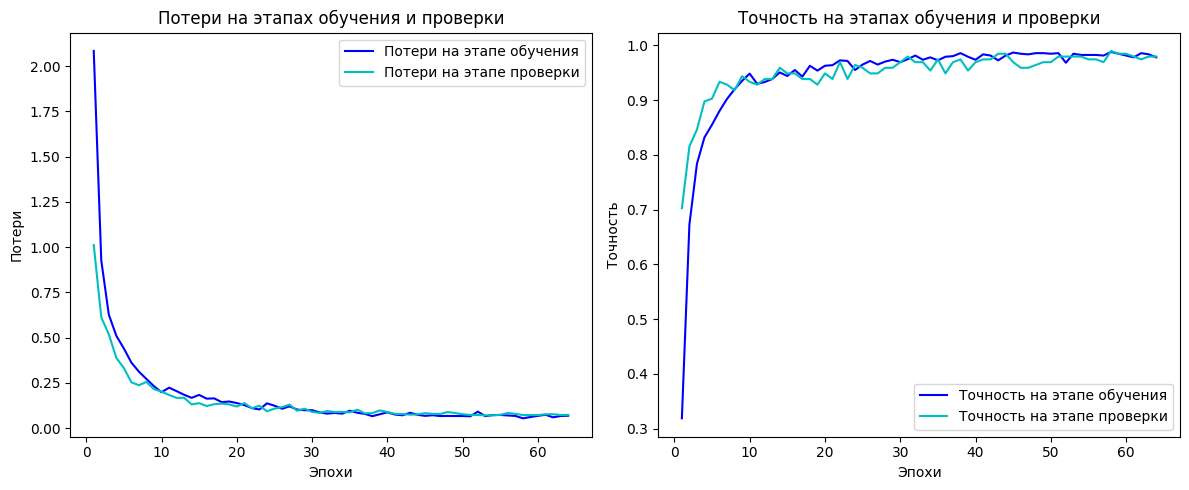

In [361]:
fit_model(model_3, "model_3.keras")

In [363]:
evaluate_model("model_3.keras")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.9692 - loss: 0.0747
Точность на тестовых данных: 0.969


### Дообучение верхних слоёв ResNet

In [366]:
base_model.trainable = True

for layer in base_model.layers[:150]:
  layer.trainable = False

print(f"Обучаемых слоёв: {len([l for l in base_model.layers if l.trainable])}")

Обучаемых слоёв: 40


In [368]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)  
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(13, activation="softmax")(x)
model_4 = keras.Model(inputs=inputs, outputs=outputs)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 935ms/step - accuracy: 0.7692 - loss: 0.7799 - val_accuracy: 0.4000 - val_loss: 13.6053 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 863ms/step - accuracy: 0.9231 - loss: 0.2648 - val_accuracy: 0.2872 - val_loss: 57.2181 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 835ms/step - accuracy: 0.9187 - loss: 0.2800 - val_accuracy: 0.1744 - val_loss: 40.8060 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 894ms/step - accuracy: 0.9363 - loss: 0.2253 - val_accuracy: 0.6615 - val_loss: 3.2395 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 858ms/step - accuracy: 0.9714 - loss: 0.1064 - val_accuracy: 0.6103 - val_loss: 5.9722 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 892ms/step - accuracy: 0.9659 - loss: 0.1314 - val_accuracy: 0.9641 - val_loss: 0.1047 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 871ms/step - accuracy: 0.9835 

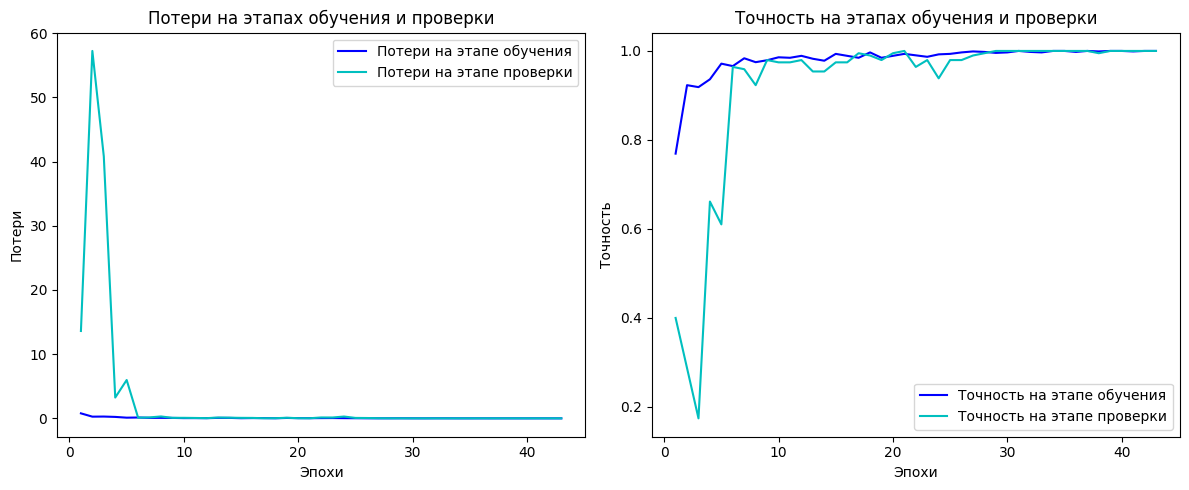

In [370]:
fit_model(model_4, "model_4.keras")

In [372]:
evaluate_model("model_4.keras")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 423ms/step - accuracy: 0.9949 - loss: 0.0109
Точность на тестовых данных: 0.995
